<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.random import uniform, normal
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg

In [397]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()                                                    # o plt.save_en_algún_formato()

In [398]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

Esta función calcula los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$. Se da mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [399]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)` con la matrix de pesos `W`.

In [400]:
def local_regression(X,W,Xo):
    # W     : Matriz diagonal de pesos
    # X     : Regresores
    # xo    : punto donde se desea hacer la predicción.
    Xt = X.T  # Calcula transpuesta de X
    A = np.matmul(Xt, np.matmul(W,X)) 
    A = np.linalg.inv(A)   # Calcula inversa de A
    B = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente `X` serán los datos de demanda del día anterior, y los datos independiente `Y` serán los datos de días con una mayor correlación con `X`. En esta sección, aplicaremos técnicas de regresión local con multiples regresores `X`. Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

## Muestreo **bootstrap** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple

In [401]:
df  = pd.read_csv('demanda.csv')
X   = pd.DataFrame(df[['X1','X2']]).to_numpy()
X   = pd.DataFrame(df[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()

A continuación se calcula un modelo de regresión lineal múltiple para una de las muestras `X_train` elegidas aleatoriamente un 50% de datos del total del conjunto `X`. Los datos de error (MAE) de todas las réplicas del muestreo aleatorio se guardan en la lista `bootstrap_ols`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

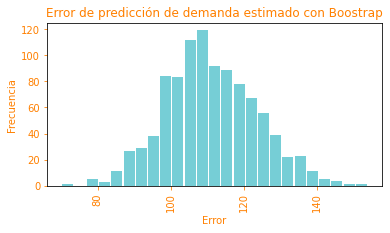

0    111.025802
dtype: float64
0    12.583897
dtype: float64


In [402]:
bootstrap_ols= []
replicas = 1000
for rep in range(replicas):
    a = np.arange(0,X.shape[0])
    b = np.sort(np.random.choice(a, replace=False, size = int(len(a)*0.9)))
    X_train = np.delete(X, b, axis = 0)
    Y_train = np.delete(Y, b, axis = 0)
    
    olsmod = sm.OLS(Y_train, X_train)
    olsres = olsmod.fit()
    Y_pred = olsres.predict(X_train)  
    bootstrap_ols.append(mean_absolute_error(Y_train,Y_pred))

dfb = pd.DataFrame((np.asarray(bootstrap_ols)).T)
bootstrap_mean = dfb.mean(numeric_only = True)
bootstrap_std = dfb.std(numeric_only = True)
dibuja_hist(dfb,colour='#76ced6',name='hist_t7_1.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Boostrap")
print(bootstrap_mean)
print(bootstrap_std)

## Muestreo **cross-validation** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple
En esta función se calcula un modelo de regresión lineal múltiple para cada una de las una de las muestras `X_test` extraidas del total del conjunto de entrenamiento `X_train`. Los datos de error del muestreo cross-validation se guardan en la lista cross_ols.

576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

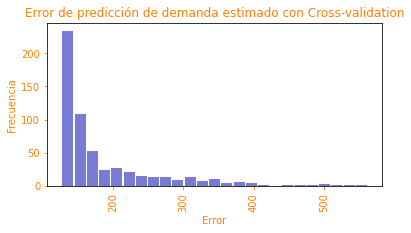

0    184.102077
dtype: float64
0    76.380279
dtype: float64


In [407]:
cross_ols_fx = []
nblocks    = 100
nblocks    = X.shape[0] 
print(X.shape[0] )
size = int( X.shape[0] / nblocks)
intervals = np.arange(size, X.shape[0], size)

for i in intervals:  
    a = np.arange(0,X.shape[0])
    b = np.arange(i-size,i)
    c = np.sort(np.setdiff1d(a, b)) #El complemento del conjunto seleccionado
    X_test  = np.delete(X, b, axis = 0)
    Y_test  = np.delete(Y, b, axis = 0)    
    X_train = np.delete(X, c, axis = 0)
    Y_train = np.delete(Y, c, axis = 0)

    olsmod  = sm.OLS(Y_train, X_train)
    olsres  = olsmod.fit()
    Y_pred  = olsres.predict(X_test)  
    error = abs(Y_test - Y_pred)
    cross_ols_fx.append(mean_absolute_error(Y_test,Y_pred))

dfb = pd.DataFrame((np.asarray(cross_ols_fx)).T)
cross_mean_fx = dfb.mean(numeric_only = True)
cross_std_fx = dfb.std(numeric_only = True)
dibuja_hist(dfb,colour='#777bd4',name='hist_t7_2.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Cross-validation")
print(cross_mean_fx)
print(cross_std_fx)

Esta versión de cross-validation elige aleatoriamente el inicio de las muestras de prueba X_test

[  5   6   7  11  13  15  19  20  21  25  28  35  52  54  60  62  63  64
  65  69  73  75  82  86  89  91  99 100 102 106 107 111 115 121 127 128
 133 134 143 144 147 148 149 152 154 159 160 163 164 168 170 178 183 185
 192 194 195 201 203 207 209 210 214 220 222 223 224 226 227 232 235 241
 242 247 248 249 253 254 256 257 259 267 272 273 275 281 284 290 291 292
 297 304 305 313 318 319 320 322 326 327 328 330 332 337 345 346 348 349
 356 357 359 366 369 374 376 382 384 386 387 388 398 400 401 403 405 407
 410 411 413 414 420 425 426 427 430 433 434 436 441 442 446 454 459 462
 466 468 472 475 479 481 490 491 492 493 496 498 499 505 506 510 511 513
 521 523 531 532 535 538 539 545 548 549 551 552 554 556 563 566 568 569]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

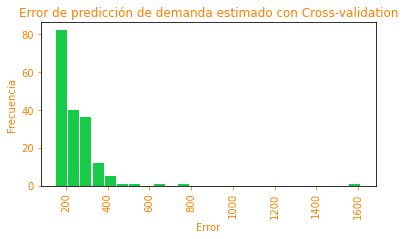

0    247.424366
dtype: float64
0    133.732571
dtype: float64


In [415]:
cross_ols = []
nblocks   = 10
size = int( X.shape[0] / nblocks)

replicas = 180
arr = np.sort(np.random.choice(a, replace=False, size = replicas))
print(arr)
for i in arr:

      a = np.arange(1,X.shape[0])
      b = np.arange(i-size,i)
      c = np.sort(np.setdiff1d(a, b)) #El complemento del conjunto seleccionado
      X_test  = np.delete(X, b, axis = 0)
      Y_test  = np.delete(Y, b, axis = 0)    
      X_train = np.delete(X, c, axis = 0)
      Y_train = np.delete(Y, c, axis = 0)

      olsmod  = sm.OLS(Y_train, X_train)
      olsres  = olsmod.fit()
      Y_pred  = olsres.predict(X_test)  
      error = abs(Y_test - Y_pred)
      cross_ols.append(mean_absolute_error(Y_test,Y_pred))

dfb = pd.DataFrame((np.asarray(cross_ols)).T)
cross_mean = dfb.mean(numeric_only = True)
cross_std = dfb.std(numeric_only = True)
dibuja_hist(dfb,colour='#17cb49',name='hist_t7_3.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Cross-validation")
print(cross_mean)
print(cross_std)